In [ ]:
from pathlib import Path
# import os
# import sys

# sys.path.append(Path(os.path.abspath('')).parent)
# os.chdir(Path(os.path.abspath('')).parent)

import numpy as np
import pandas as pd 
import xarray as xr


import config.settings as cset
from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            focus_countries,
                            focus_countries_names,
                            focus_countries_colors, 
                            focus_scenarios_color_dict,
                            focus_scenarios_labels,
                            focus_scenarios,
                            cmap_diverging,
                            cmap_negref
                            )

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box
from matplotlib.gridspec import GridSpec

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['ps.fonttype'] = 'truetype'

## Load Data

a. GMT

In [2]:
gmt_ds = pd.read_csv(cset.path_MESMER_char / f'gmt_dataset.csv', index_col = 0)


b. GDP

In [101]:
gdp_df   = pd.read_csv(cset.file_burke).loc[:, ['iso', 'scen', 'run', 'year', 'diff_SSP2', 'SSP2', 'SSP2_clim']]
gdp_df = gdp_df[gdp_df.scen != 'Ref1p5']
gdp_df.loc[gdp_df.scen == 'Refv2', 'scen'] = 'Ref'
gdp_df['scen_run'] = gdp_df['scen'] + '_' + gdp_df['run'].astype(str)

c. local temperature 

In [102]:
tas_df = pd.read_csv(cset.file_tas)
iso = 'IND'
tas_tmp = tas_df[(tas_df.iso == iso) & (tas_df.run.str.contains('ssp534-over'))].loc[:, 'tas'].values.reshape(100, -1).T

In [103]:
gdp_ref = gdp_df[(gdp_df.scen == 'ssp534-over') & (gdp_df.iso == iso) & (gdp_df.year == 2015)].loc[:, 'SSP2_clim'].values.mean()
gdp_tmp = gdp_df[(gdp_df.scen == 'ssp534-over') & (gdp_df.iso == iso)].loc[:, 'SSP2_clim'].values.reshape(-1,100)/gdp_ref*100

## Plot

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_66720/279154611.py:79: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


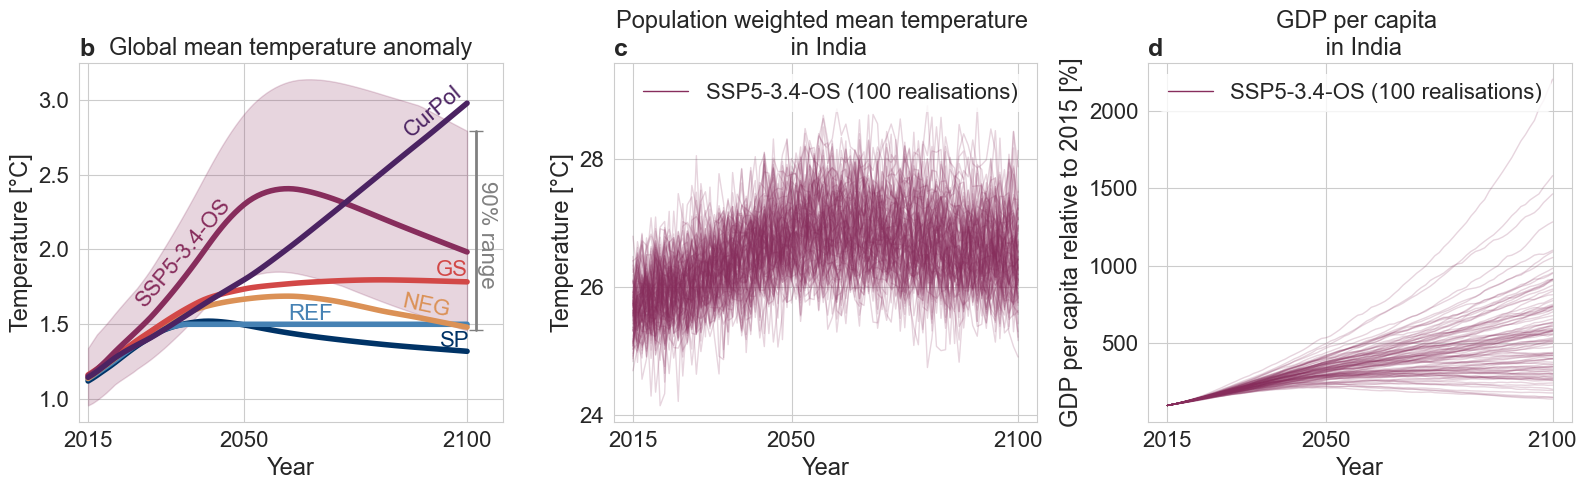

In [104]:
with sns.axes_style('whitegrid'):
    fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

    ax = axes[0] 
    for i, scenario in enumerate(focus_scenarios):
        ax.plot(gmt_ds.index, 
                gmt_ds.loc[:, gmt_ds.columns.str.contains(scenario)].values.mean(axis = 1), 
                color = focus_scenarios_color_dict[scenario],
                lw = 4,
                label = focus_scenarios_labels[i])
        if scenario == 'ssp534-over':
            ax.fill_between(gmt_ds.index, 
                            np.quantile(gmt_ds.loc[:, gmt_ds.columns.str.contains(scenario)].values, 0.05, axis = 1), 
                            np.quantile(gmt_ds.loc[:, gmt_ds.columns.str.contains(scenario)].values, 0.95, axis = 1),
                            color = focus_scenarios_color_dict[scenario],
                            alpha = .2)
    ax.text(2085, 2.75, 'CurPol', color = focus_scenarios_color_dict['CurPol'], fontsize = labelsize_medium, rotation = 40)
    ax.text(2094, 1.35, 'SP', color = focus_scenarios_color_dict['SP'], fontsize = labelsize_medium, rotation = 0)
    ax.text(2060, 1.53, 'REF', color = focus_scenarios_color_dict['Ref'], fontsize = labelsize_medium, rotation = 0)
    ax.text(2085, 1.55, 'NEG', color = focus_scenarios_color_dict['Neg'], fontsize = labelsize_medium, rotation = -12)
    ax.text(2093, 1.82, 'GS', color = focus_scenarios_color_dict['GS'], fontsize = labelsize_medium, rotation = 0)
    ax.text(2025, 1.62, 'SSP5-3.4-OS', color = focus_scenarios_color_dict['ssp534-over'], fontsize = labelsize_medium, rotation = 50)
    ax.plot([2102, 2102], np.quantile(gmt_ds.loc[:, gmt_ds.columns.str.contains('ssp534-over')].values, q = [0.05, 0.95], axis = 1)[:,-1], marker = '_', lw = 2, color = 'grey',
            markersize = 10)
    ax.text(2102.3, 2.1, rotation = 270, s = '90% range', fontsize = labelsize_medium, color = 'grey', va = 'center')
    
    ax.set_xticks([2015, 2050, 2100],
                  [2015, 2050, 2100],
                   fontsize= labelsize_medium)
    ax.set_yticks([1.0, 1.5, 2.0, 2.5, 3.0], 
                  [1.0, 1.5, 2.0, 2.5, 3.0],
                  fontsize= labelsize_medium)
    ax.set_xlabel('Year', 
                  fontsize=labelsize_large)
    ax.set_ylabel('Temperature [°C]', 
                  fontsize=labelsize_large)
    ax.set_xlabel('Year', 
                  fontsize = labelsize_large)
    ax.set_title('Global mean temperature anomaly', 
                 fontsize = labelsize_large)
    ax.set_xlim(2013, 2108)
    
    ax = axes[1]
    ax.plot(gmt_ds.index, tas_tmp, color = focus_scenarios_color_dict['ssp534-over'], lw = 1, alpha = .2)
    ax.plot([], [], color = focus_scenarios_color_dict['ssp534-over'], lw = 1, alpha = 1, label = 'SSP5-3.4-OS (100 realisations)')
    ax.set_xticks([2015, 2050, 2100], 
                  [2015, 2050, 2100], 
                  fontsize = labelsize_medium)
    ax.set_yticks([24,26,28], 
                  [24,26,28], 
                  fontsize = labelsize_medium)
    ax.set_xlabel('Year', fontsize = labelsize_large)
    ax.set_ylabel('Temperature [°C]', fontsize = labelsize_large)
    ax.set_title('Population weighted mean temperature \n in India', fontsize = labelsize_large)
    ax.legend(fontsize = labelsize_medium, 
              facecolor = (1,1,1,0.7),
              edgecolor = 'None')
    ax.set_ylim(23.9, 29.5)
    
    ax = axes[2]
    ax.plot(gmt_ds.index, gdp_tmp, color = focus_scenarios_color_dict['ssp534-over'], lw = 1, alpha = .2)
    ax.plot([], [], color = focus_scenarios_color_dict['ssp534-over'], lw = 1, alpha = 1, label = 'SSP5-3.4-OS (100 realisations)')
    ax.set_xticks([2015, 2050, 2100],
                  [2015, 2050, 2100], 
                  fontsize = labelsize_medium)
    ax.set_yticks([500,1000,1500,2000], 
                  [500,1000,1500,2000], 
                  fontsize = labelsize_medium)
    ax.set_xlabel('Year', fontsize = labelsize_large)
    ax.set_ylabel('GDP per capita relative to 2015 [%]', 
                  fontsize = labelsize_large)
    ax.set_title('GDP per capita \n in India', fontsize = labelsize_large)  
    ax.legend(fontsize = labelsize_medium, 
            facecolor = (1,1,1,0.7),
            edgecolor = 'None')
    
    for i, ax in enumerate(axes): 
        ax.text(0.0, 1.07, ['b', 'c', 'd'][i], transform=ax.transAxes,fontsize=labelsize_large+1, fontweight='bold', va='top')
    plt.tight_layout()
    plt.savefig(cset.path_GRAPHICS / '001_stylised_modelling_chain.pdf', dpi = 600)
    plt.show()